### upset plots for pc1/2/control overlaps


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re

import upsetplot as up
from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000

In [2]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
clusters_dir = config['clusters_dir']
eqtl_output_dir = config['eqtl_output_dir']
pcqtl_output_dir = config['pcqtl_output_dir']
overlap_output_dir = config['overlap_output_dir']


# load in the tissue ids 
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])


### Upset membership plot

In [4]:
# add pc 1 and 2 specific columns
def count_pc(id_list, pc_num):
    return sum([f'pc{pc_num}' in phenotype_id for phenotype_id in id_list])

#### Overlapping lead variants

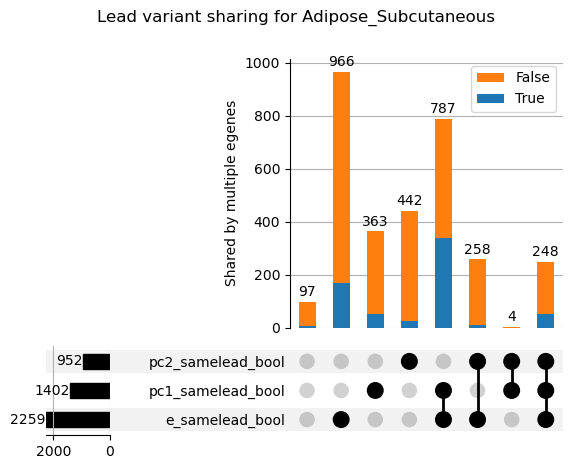

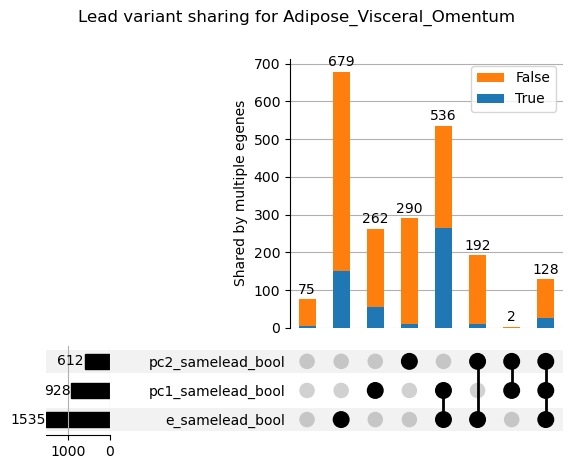

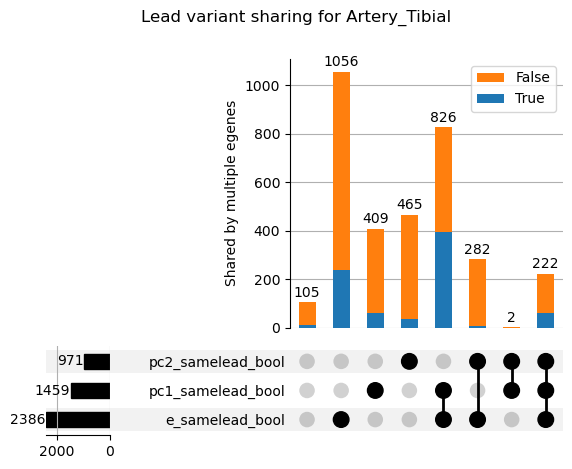

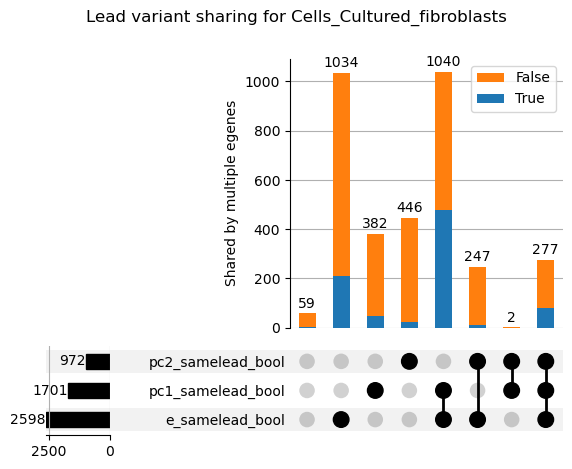

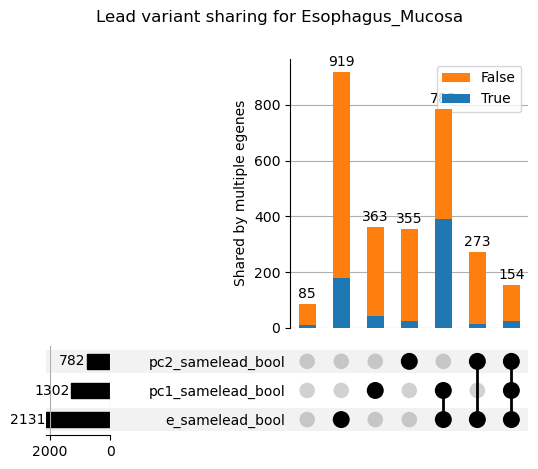

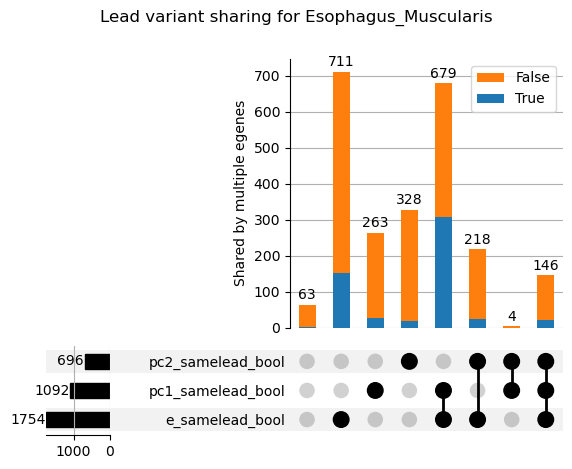

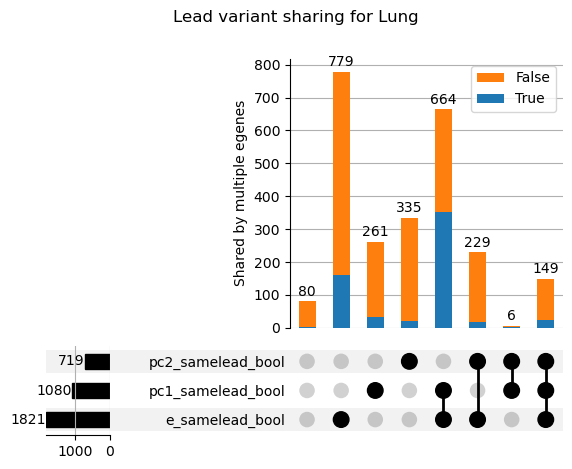

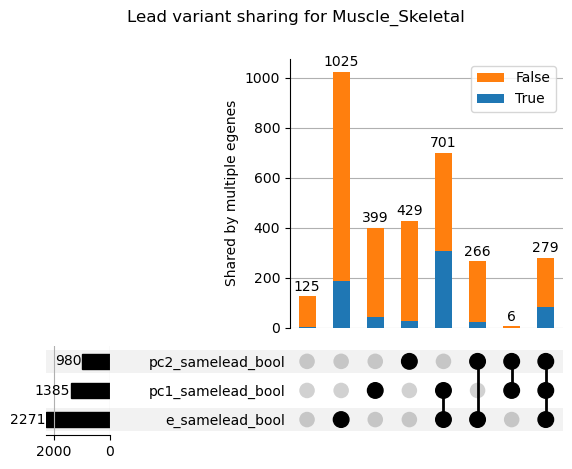

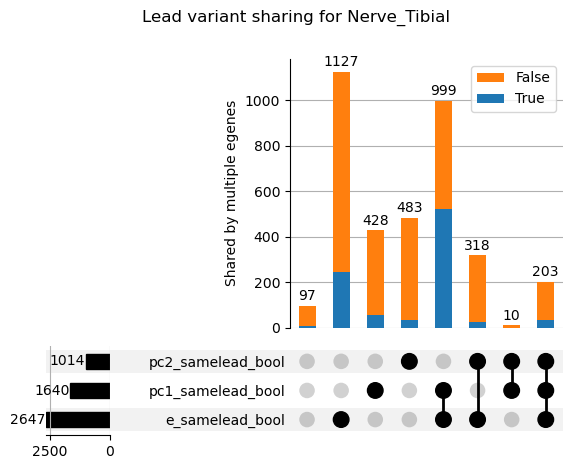

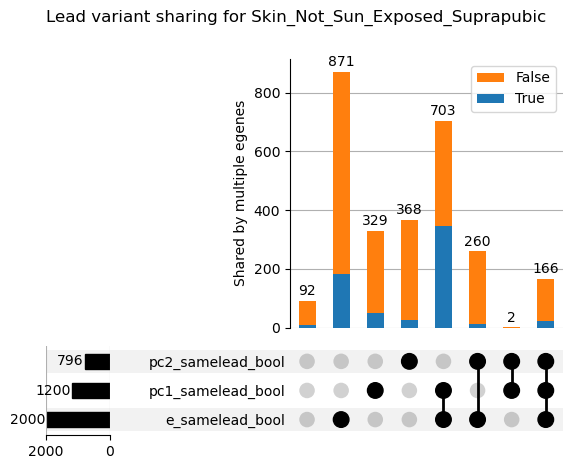

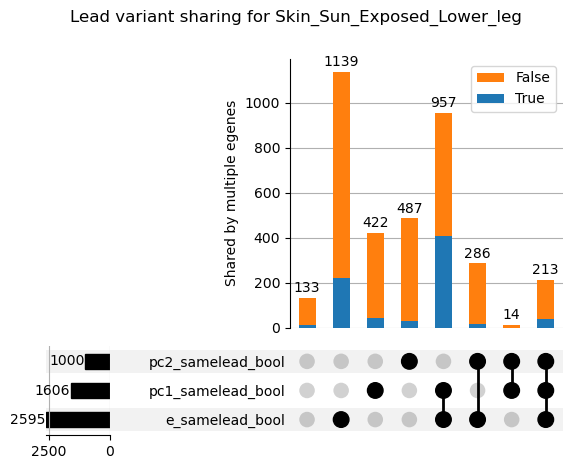

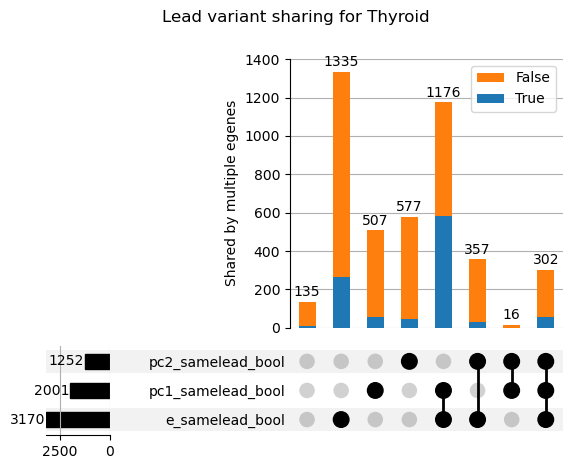

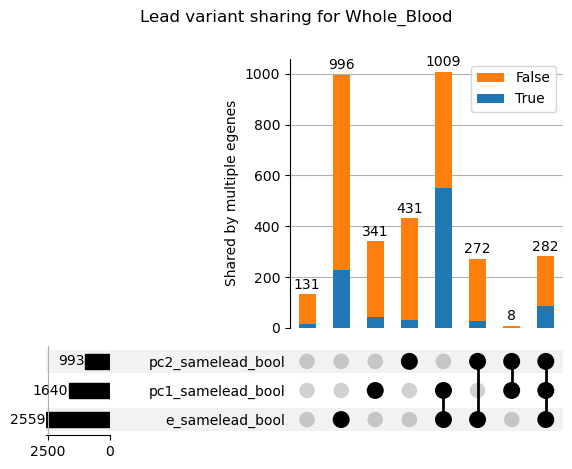

In [29]:


# upset for each tissue individually
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')

    # add pc 1 and 2 specific columns
    overlap_df['num_pc1_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
    overlap_df['num_pc2_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=2)
    overlap_df['num_pc1_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
    overlap_df['num_pc2_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=2)
    overlap_df['e_samelead_bool'] = overlap_df['num_e_samelead'] > 0
    overlap_df['pc1_samelead_bool'] = overlap_df['num_pc1_samelead'] > 0
    overlap_df['pc2_samelead_bool'] = overlap_df['num_pc2_samelead'] > 0
    overlap_df['multiple_e_shared'] = overlap_df['num_e_overlap']>1    

    upset = overlap_df.set_index('e_samelead_bool').set_index('pc1_samelead_bool', append=True).set_index('pc2_samelead_bool', append=True)

    upset = up.UpSet(upset, intersection_plot_elements=0,show_counts=True)  # disable the default bar chart
    upset.add_stacked_bars(by="multiple_e_shared", title="Shared by multiple egenes", elements=8)
    upset.plot()
    plt.suptitle(f'Lead variant sharing for {tissue_id}')
    plt.show()

In [30]:
def get_upset_to_plot(overlap_df, num_pcs = 2):
    # group by lead variants, see which cs/phenotype combos they appear in
    lead_var_phenotypes = overlap_df.groupby('lead_variant_id')['cs_full_id'].apply(list)
    upset_df = pd.DataFrame(pd.Series(lead_var_phenotypes, name='cs_id_list'))

    # make indicator columns
    upset_df['e_shared'] = upset_df['cs_id_list'].astype(str).str.contains('_e')
    for i in range(num_pcs):
        upset_df[f'pc{i+1}_shared'] = upset_df['cs_id_list'].astype(str).str.contains(f'_pc{i+1}')

    # add columns indicating the number of shared egenes
    upset_df['num_e_shared'] = upset_df['cs_id_list'].astype(str).str.count('_e')/2
    upset_df['multiple_e_shared'] = upset_df['num_e_shared']>1

    # make upset_plot object
    upset_to_plot = upset_df.set_index('e_shared')
    for i in range(num_pcs):
        upset_to_plot = upset_to_plot.set_index(f'pc{i+1}_shared', append=True)
    return upset_to_plot

def plot_upset(overlap_df, title, instersection_plot=True, num_pcs=2, min_subset_size=0):
    upset_to_plot=get_upset_to_plot(overlap_df, num_pcs=num_pcs)
    if instersection_plot:
        upset = up.UpSet(upset_to_plot, intersection_plot_elements=0,show_counts=True, min_subset_size=min_subset_size)  # disable the default bar chart
        upset.add_stacked_bars(by="multiple_e_shared", title="Shared by multiple egenes", elements=8)
        upset.plot()
    else:
        upset_to_plot.plot(show_counts=True, min_subset_size=min_subset_size)
    plt.suptitle(title)
    plt.show()

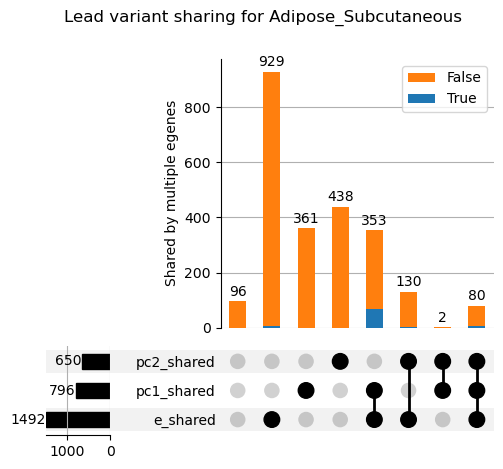

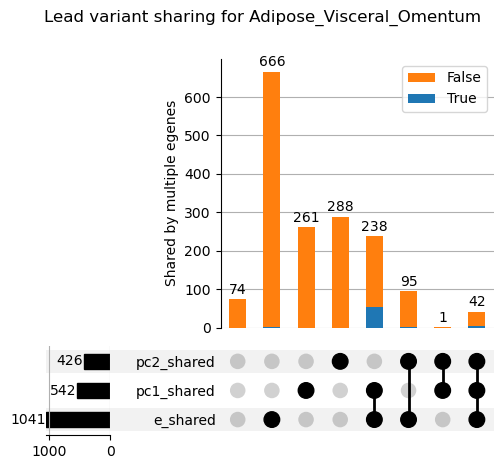

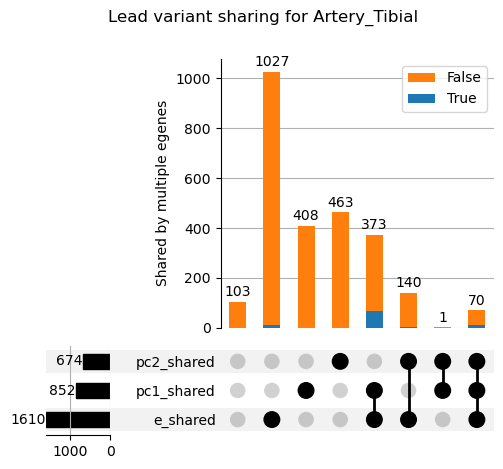

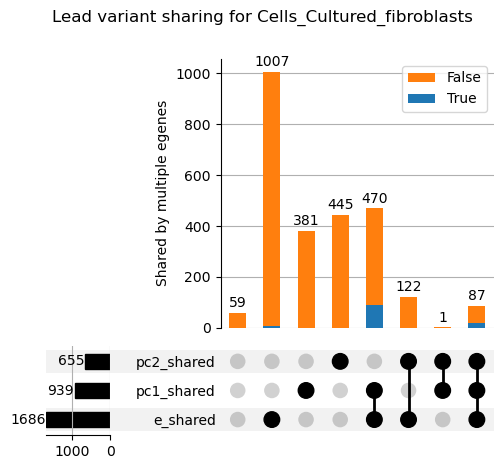

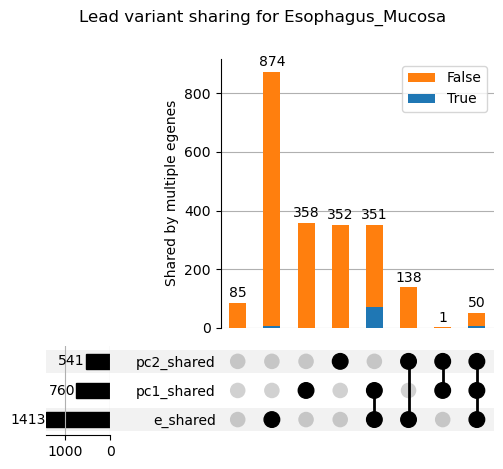

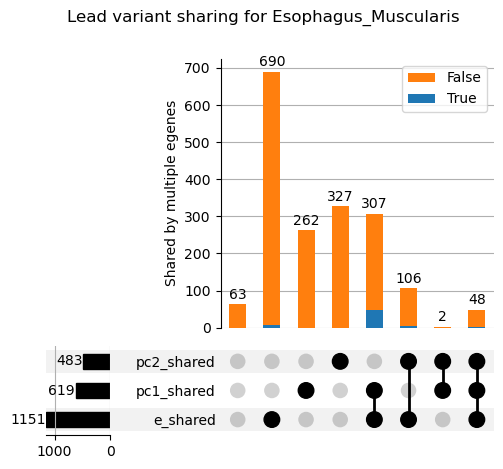

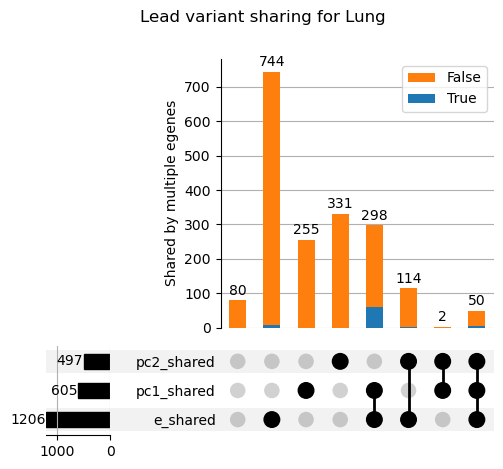

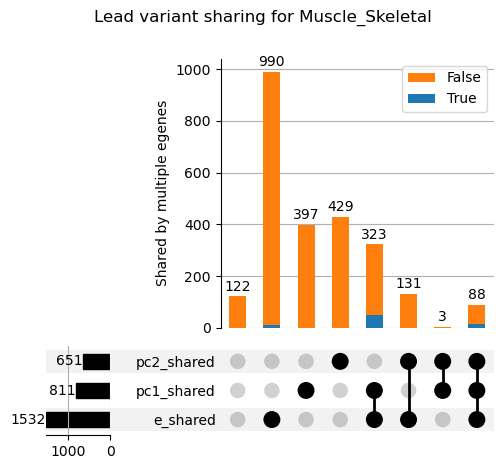

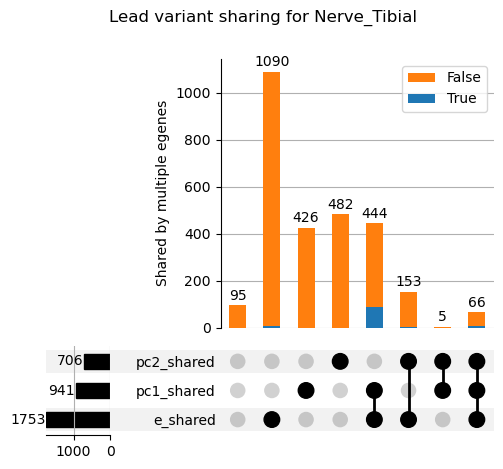

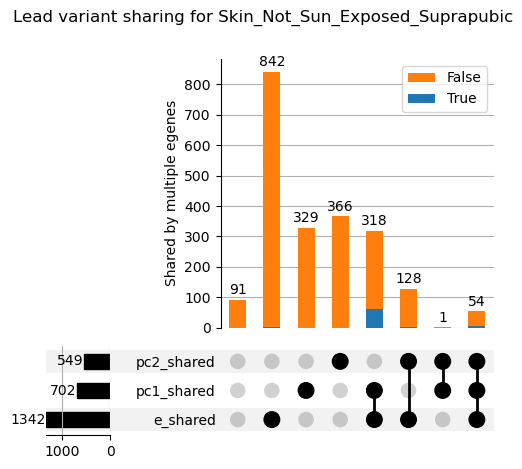

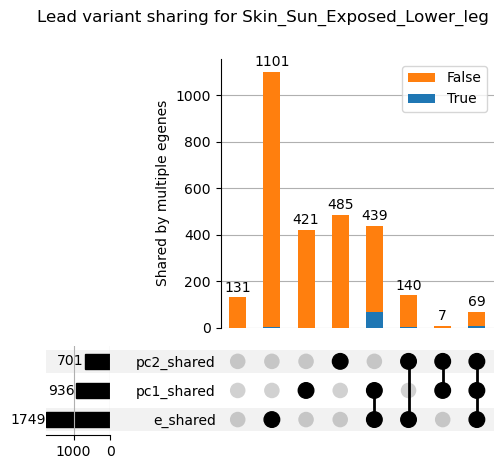

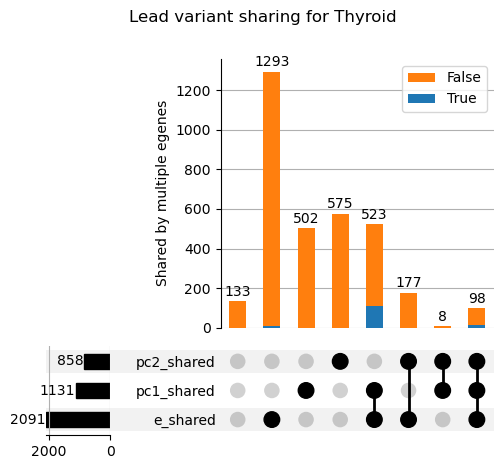

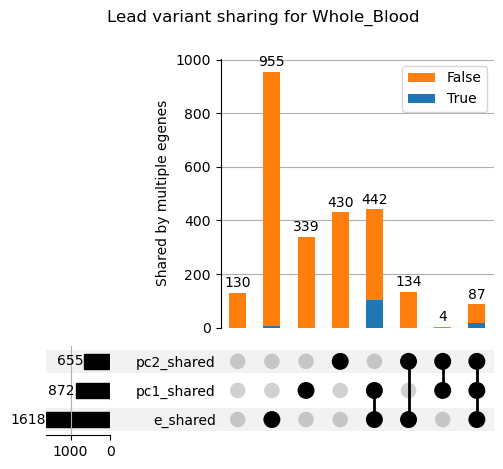

In [31]:
# upset for each tissue individually
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')
    overlap_df['num_pc1_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
    overlap_df['num_pc2_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=2)
    overlap_df['num_pc1_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
    overlap_df['num_pc2_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=2)
    plot_upset(overlap_df, title=f'Lead variant sharing for {tissue_id}')


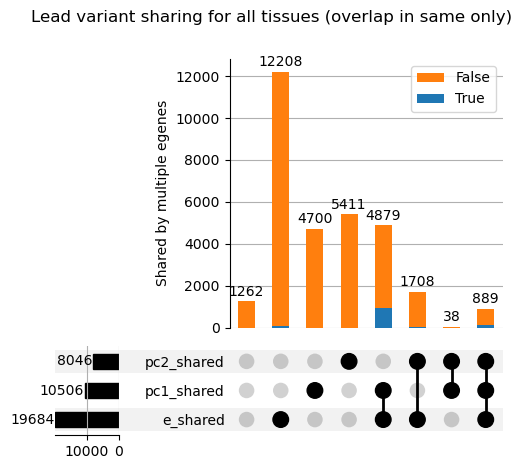

In [32]:
# all tissues, but must overlap in same tissue
# stacked bar to show if multiple egenes overlap or not
upset_dfs=[]
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')
    overlap_df['num_pc1_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
    overlap_df['num_pc2_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=2)
    overlap_df['num_pc1_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
    overlap_df['num_pc2_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=2)
    upset_dfs.append(get_upset_to_plot(overlap_df))
full_upset_df = pd.concat([df.assign(tissue_id=n) for df, n in zip(upset_dfs, tissue_ids)])

upset = up.UpSet(full_upset_df, intersection_plot_elements=0,show_counts=True)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_shared", title="Shared by multiple egenes", elements=8)
upset.plot()
plt.suptitle('Lead variant sharing for all tissues (overlap in same only)')
plt.show()

In [33]:
# all tissues, but must overlap in same tissue
# stacked bar to show if multiple egenes overlap or not
num_pcs = 10
upset_dfs=[]
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')
    for i in range(num_pcs):
        overlap_df[f'num_pc{i+1}_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=i+1)
    upset_dfs.append(get_upset_to_plot(overlap_df, num_pcs = num_pcs))
full_upset_df = pd.concat([df.assign(tissue_id=n) for df, n in zip(upset_dfs, tissue_ids)])

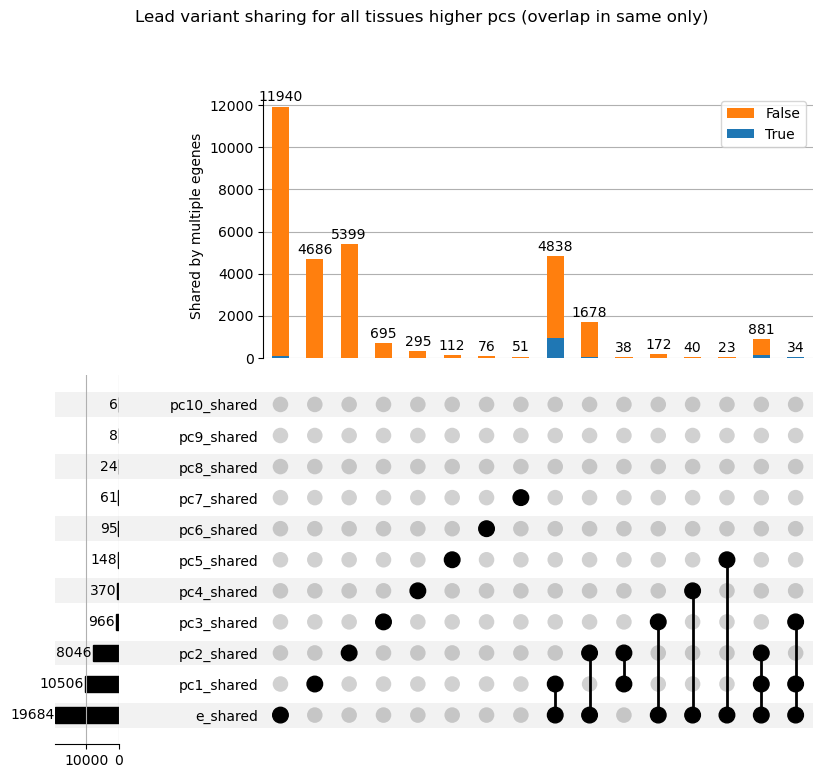

In [34]:
upset = up.UpSet(full_upset_df, intersection_plot_elements=0,show_counts=True, min_subset_size=20)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_shared", title="Shared by multiple egenes", elements=8)
upset.plot()
plt.suptitle('Lead variant sharing for all tissues higher pcs (overlap in same only)')
plt.show()

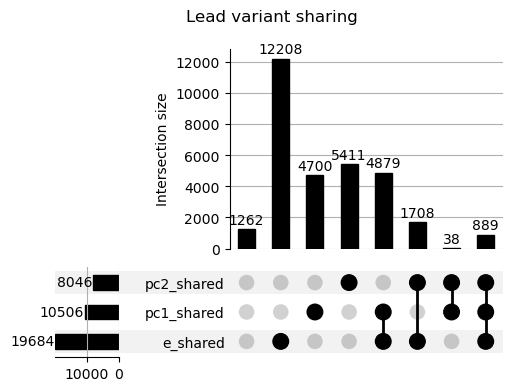

In [35]:
# all tissues, but must overlap in same tissue, without colored bars
# stacked bar to show if multiple egenes overlap or not
upset_dfs=[]
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')
    overlap_df['num_pc1_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
    overlap_df['num_pc2_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=2)
    overlap_df['num_pc1_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
    overlap_df['num_pc2_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=2)
    
    upset_dfs.append(get_upset_to_plot(overlap_df))
full_upset_df = pd.concat([df.assign(tissue_id=n) for df, n in zip(upset_dfs, tissue_ids)])

upset = up.UpSet(full_upset_df, show_counts=True)  # disable the default bar chart
upset.plot()
plt.suptitle('Lead variant sharing')
plt.show()

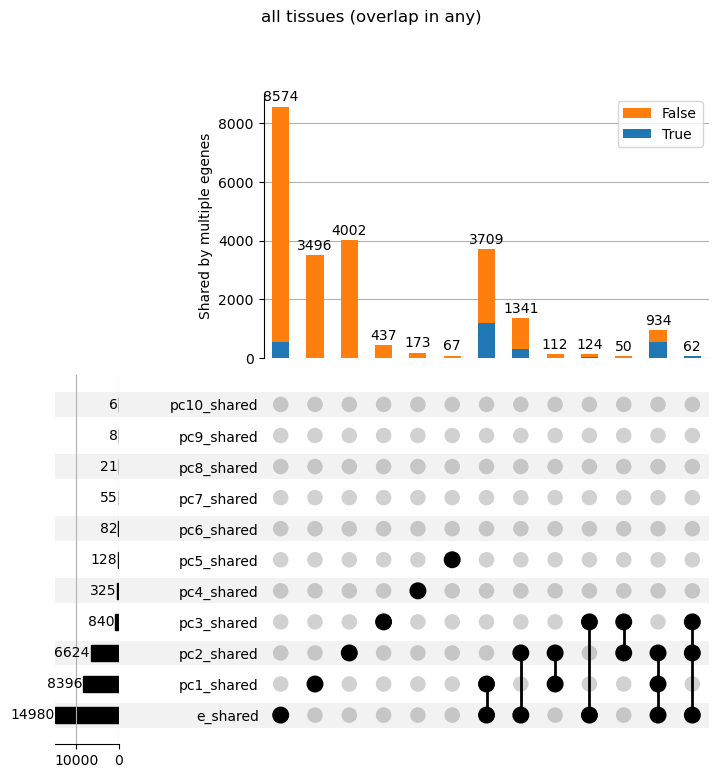

In [36]:
# upset for lead variant for all tissues (can be shared across tissues)

num_pcs = 10
overlap_dfs=[]
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_dfs.append(pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t'))
full_overlap_df = pd.concat([df.assign(tissue_id=n) for df, n in zip(overlap_dfs, tissue_ids)])
for i in range(num_pcs):
    full_overlap_df[f'num_pc{i+1}_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=i+1)

plot_upset(full_overlap_df, 'all tissues (overlap in any)', num_pcs=num_pcs, min_subset_size=50)

#### tissue specificity

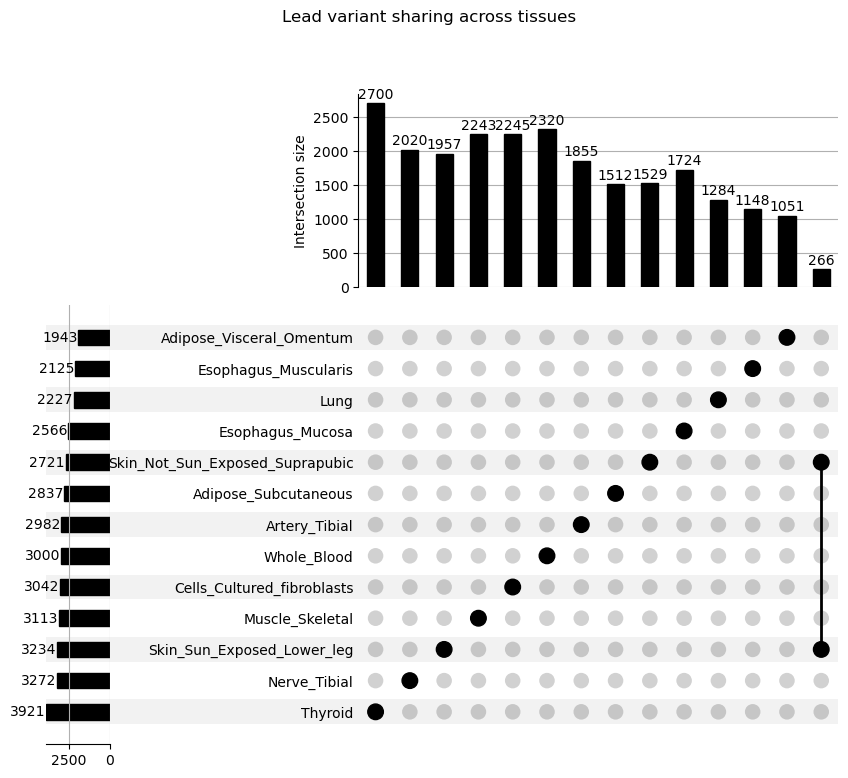

In [ ]:
cs_tissues = full_overlap_df.groupby('lead_variant_id')['tissue_id'].apply(set)
up.UpSet(up.from_memberships(cs_tissues), subset_size='count', min_subset_size=100, show_counts=True).plot()
plt.suptitle('Lead variant sharing across tissues')
plt.show()

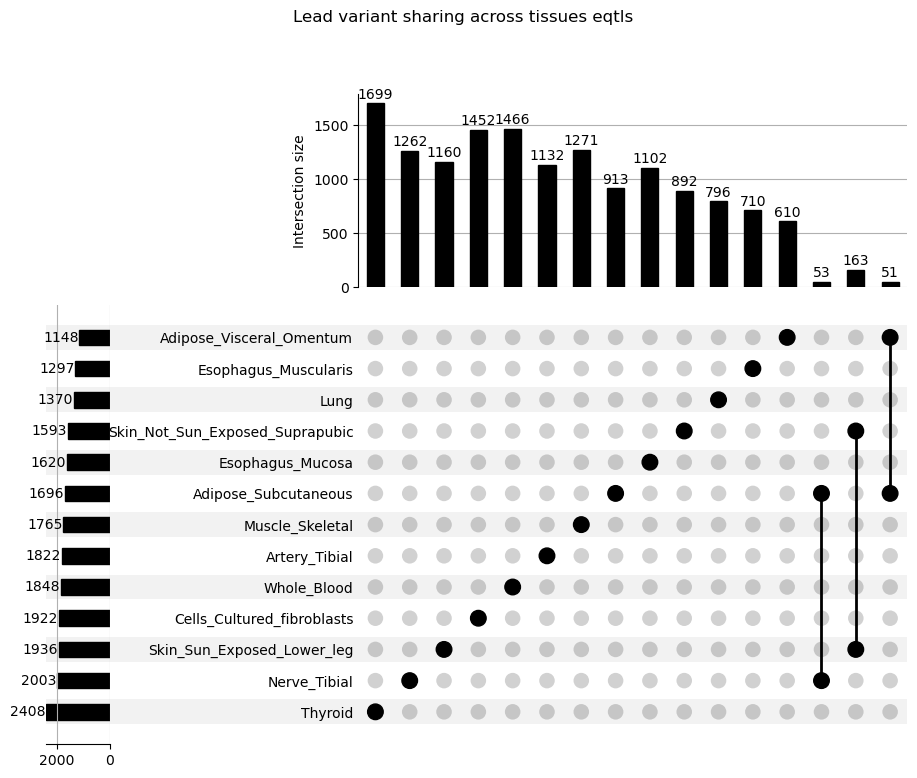

In [ ]:
cs_tissues = full_overlap_df[full_overlap_df['num_e_samelead']>0].groupby('lead_variant_id')['tissue_id'].apply(set)
up.UpSet(up.from_memberships(cs_tissues), subset_size='count', min_subset_size=50, show_counts=True).plot()
plt.suptitle('Lead variant sharing across tissues eqtls')
plt.show()

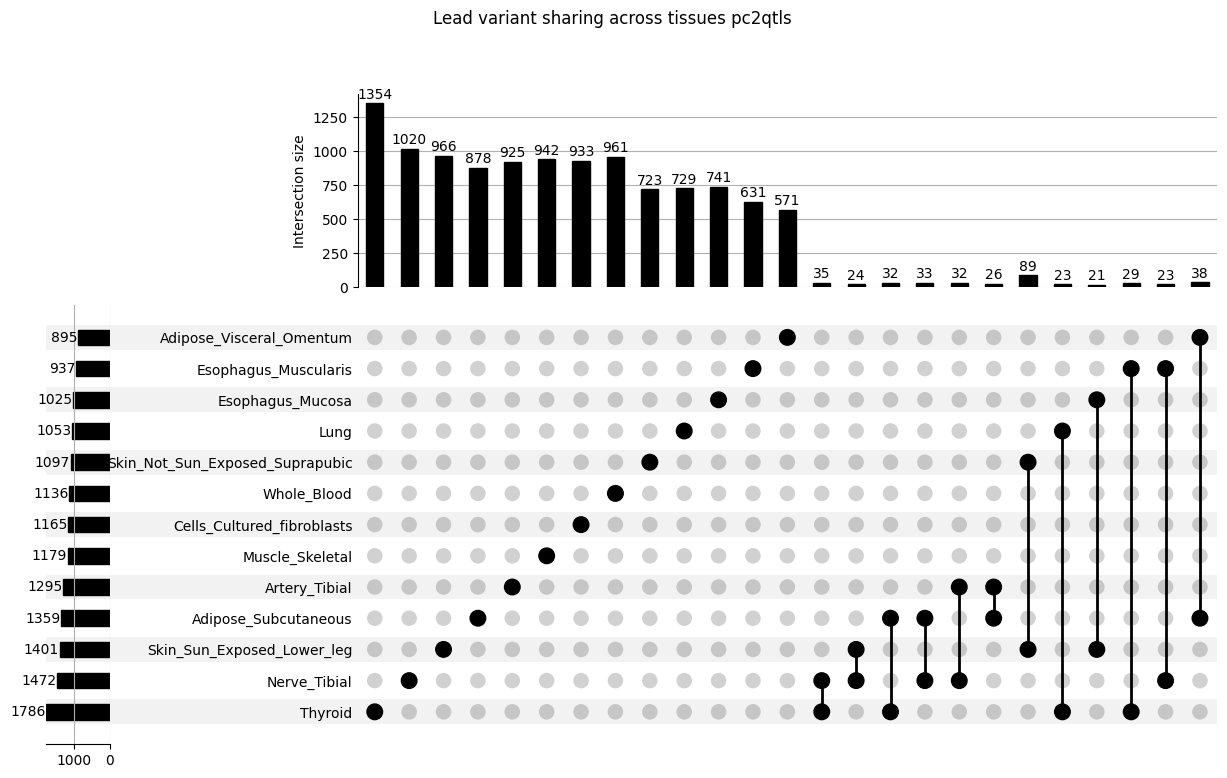

In [ ]:
cs_tissues = full_overlap_df[full_overlap_df['num_pc2_samelead'] >0].groupby('lead_variant_id')['tissue_id'].apply(set)
up.UpSet(up.from_memberships(cs_tissues), subset_size='count', min_subset_size=20, show_counts=True).plot()
plt.suptitle('Lead variant sharing across tissues pc2qtls')
plt.show()

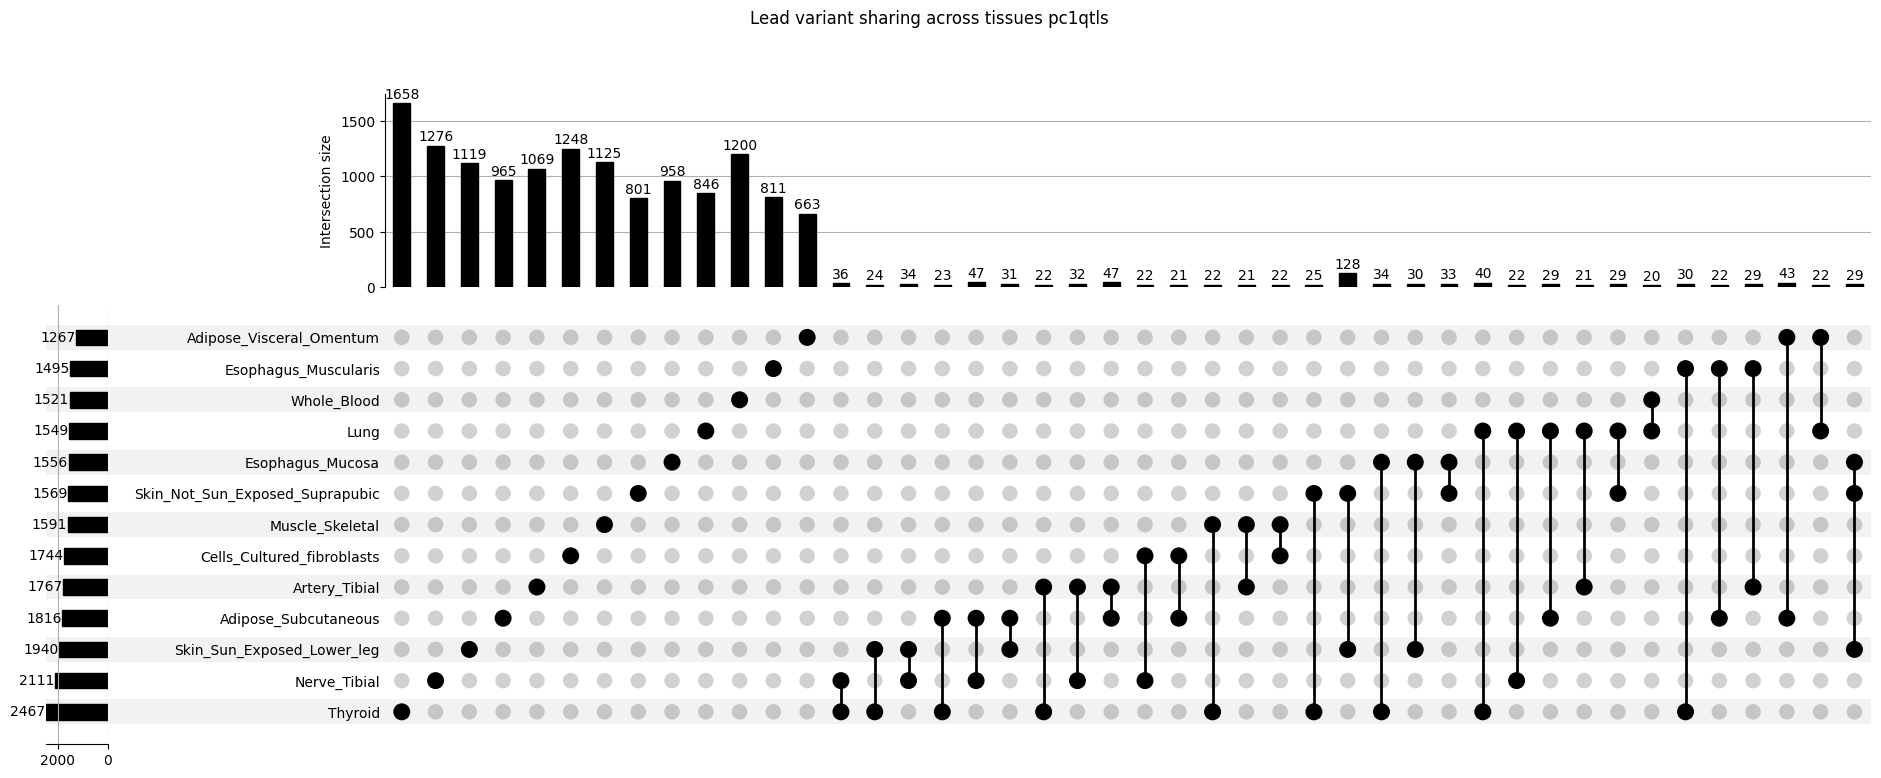

In [ ]:
cs_tissues = full_overlap_df[full_overlap_df['num_pc1_samelead'] >0].groupby('lead_variant_id')['tissue_id'].apply(set)
up.UpSet(up.from_memberships(cs_tissues), subset_size='count', min_subset_size=20, show_counts=True).plot()
plt.suptitle('Lead variant sharing across tissues pc1qtls')
plt.show()

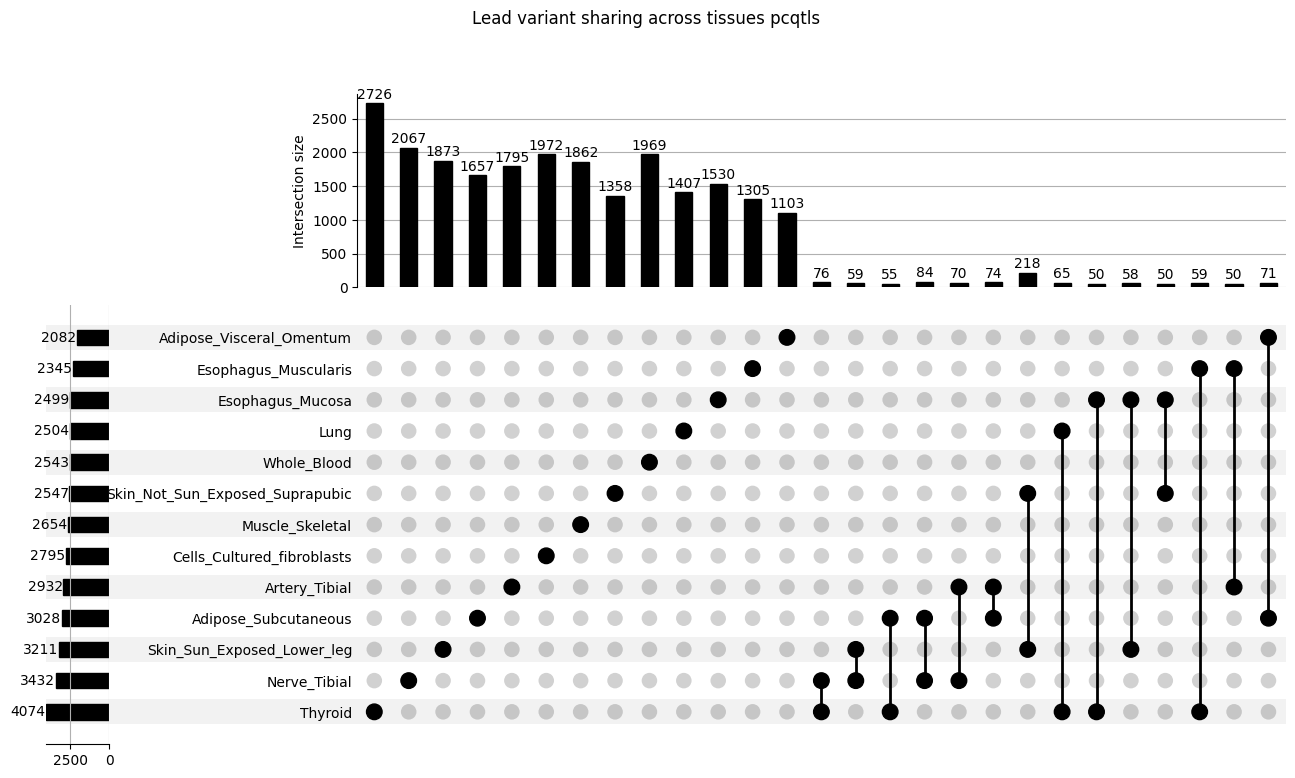

In [ ]:
full_overlap_df['num_pc_samelead'] = full_overlap_df['num_pc1_samelead'] + full_overlap_df['num_pc2_samelead']
cs_tissues = full_overlap_df[full_overlap_df['num_pc_samelead'] >0].groupby('lead_variant_id')['tissue_id'].apply(set)
up.UpSet(up.from_memberships(cs_tissues), subset_size='count', min_subset_size=50, show_counts=True).plot()
plt.suptitle('Lead variant sharing across tissues pcqtls')
plt.show()

In [ ]:
# tissue specificity fraction
num_pc_tissues = full_overlap_df[full_overlap_df['num_pc_samelead'] >0].groupby('lead_variant_id')['tissue_id'].apply(set).apply(len)
num_pc1_tissues = full_overlap_df[full_overlap_df['num_pc1_samelead'] >0].groupby('lead_variant_id')['tissue_id'].apply(set).apply(len)
num_pc2_tissues = full_overlap_df[full_overlap_df['num_pc2_samelead'] >0].groupby('lead_variant_id')['tissue_id'].apply(set).apply(len)
num_e_tissues = full_overlap_df[full_overlap_df['num_e_samelead'] >0].groupby('lead_variant_id')['tissue_id'].apply(set).apply(len)

In [ ]:
num_tissues_df = pd.concat([num_e_tissues, num_pc1_tissues, num_pc2_tissues, num_pc_tissues], keys=['eqtl', 'pc1qtl', 'pc2qtl', 'pcqtl'])
num_tissues_df = num_tissues_df.reset_index()
num_tissues_df = num_tissues_df.rename(columns={'tissue_id':'num_tissues', 'level_0':'method'})

Text(0.5, 1.0, 'Number of tissues sharing lead variant across methods')

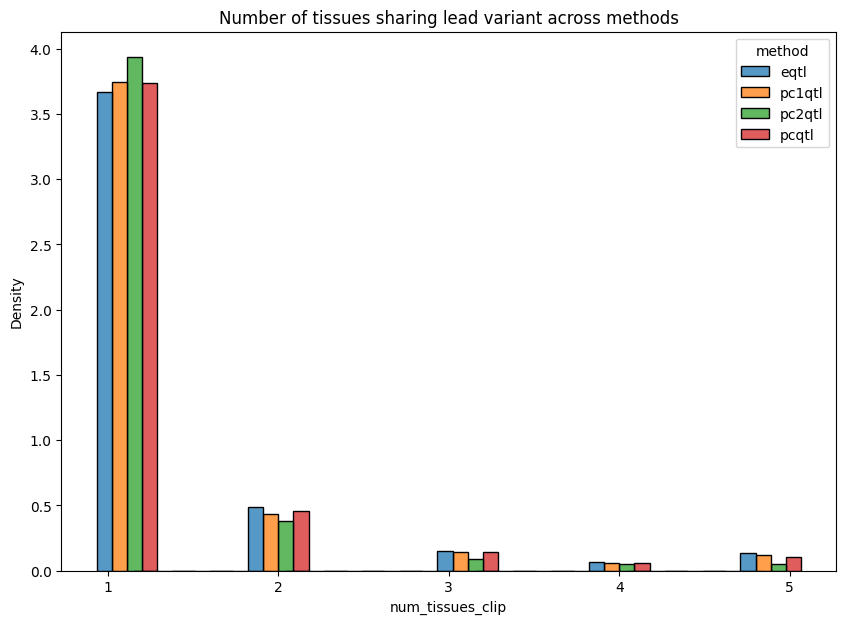

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

num_tissues_df['num_tissues_clip'] = num_tissues_df['num_tissues'].clip(0,5)
sns.histplot(num_tissues_df, hue='method', x='num_tissues_clip', stat='density', common_norm=False, ax=ax, multiple='dodge', shrink=1.6)
plt.title('Number of tissues sharing lead variant across methods')

In [ ]:
# tissue specificity fraction
num_emulti_tissues = full_overlap_df[full_overlap_df['num_e_samelead'] >1].groupby('lead_variant_id')['tissue_id'].apply(set).apply(len)
num_esingle_tissues = full_overlap_df[full_overlap_df['num_e_samelead'] ==1].groupby('lead_variant_id')['tissue_id'].apply(set).apply(len)

In [ ]:
num_tissues_df = pd.concat([num_emulti_tissues, num_esingle_tissues], keys=['eqtl multigene', 'eqtl singlegene'])
num_tissues_df = num_tissues_df.reset_index()
num_tissues_df = num_tissues_df.rename(columns={'tissue_id':'num_tissues', 'level_0':'method'})

Text(0.5, 1.0, 'Number of tissues sharing lead variant across methods')

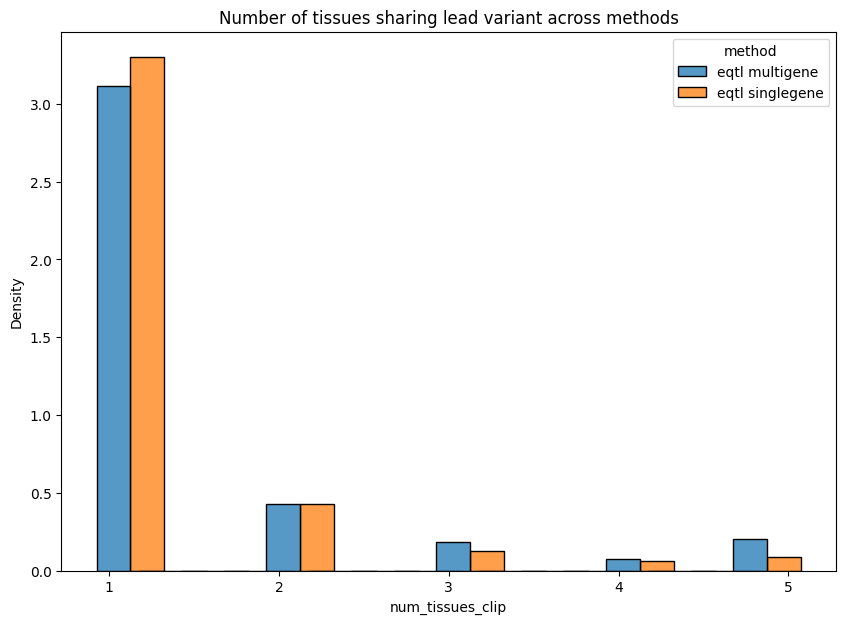

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

num_tissues_df['num_tissues_clip'] = num_tissues_df['num_tissues'].clip(0,5)
sns.histplot(num_tissues_df, hue='method', x='num_tissues_clip', stat='density', common_norm=False, ax=ax, multiple='dodge', shrink=1.6)
plt.title('Number of tissues sharing lead variant across methods')

In [ ]:
# tissue specificity fraction
num_e_tissues = full_overlap_df[full_overlap_df['num_e_samelead'] >0].groupby('lead_variant_id')['tissue_id'].apply(set).apply(len)
num_pc_tissues = full_overlap_df[full_overlap_df['num_pc_samelead'] >0].groupby('lead_variant_id')['tissue_id'].apply(set).apply(len)

In [ ]:
num_tissues_df = pd.concat([num_e_tissues, num_pc_tissues], keys=['eqtl', 'pcqtl'])
num_tissues_df = num_tissues_df.reset_index()
num_tissues_df = num_tissues_df.rename(columns={'tissue_id':'num_tissues', 'level_0':'method'})

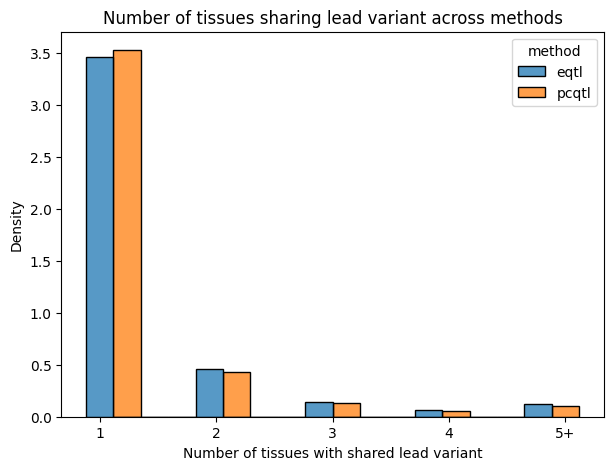

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

num_tissues_df['num_tissues_clip'] = num_tissues_df['num_tissues'].clip(0,5)
sns.histplot(num_tissues_df, hue='method', x='num_tissues_clip', stat='density', common_norm=False, ax=ax, multiple='dodge', shrink=2)
plt.title('Number of tissues sharing lead variant across methods')
plt.xlabel('Number of tissues with shared lead variant')

ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(['1', '2', '3', '4', '5+'])
plt.show()

In [ ]:
# add background eqlts

def get_lead_var(susie_df):
    return susie_df.loc[susie_df.groupby('cs_full_id')['pip'].idxmax(),['cs_full_id','variant_id']].set_index('cs_full_id')


control_veps=[]
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    control_vep = pd.read_csv(f'{prefix}/output/chr22_eqtl_annotations/{tissue_id}.v8.chr22_genes.leadvars.vep.vcf', skiprows=4, sep='\t')

    # get susie and groupby lead variant
    control_susie = pd.read_csv(f'{prefix}/output/chr22_eqtl/{tissue_id}/{tissue_id}.v8.chr22_genes.susie.txt', sep='\t', index_col=0)
    control_susie['cs_full_id'] = control_susie['phenotype_id'].astype(str) + '_e_cs' + control_susie['cs_id'].astype(str) 
    control_cs_df = pd.DataFrame(pd.Series(control_susie.groupby(['cs_full_id'])['variant_id'].apply(list), name='variant_list'))
    control_cs_df['lead_variant_id'] = get_lead_var(control_susie)

    # merge 
    control_veps.append(pd.merge(control_vep, control_cs_df, left_on='ID', right_on='lead_variant_id', how='outer'))


control_vep_df = pd.concat([df.assign(tissue_id=n) for df, n in zip(control_veps, tissue_ids)])
control_vep_df.reset_index(inplace=True, drop=True)

In [ ]:
num_control_e_tissues = control_vep_df.groupby('lead_variant_id')['tissue_id'].apply(set).apply(len)
num_e_tissues = full_overlap_df[full_overlap_df['num_e_samelead'] >0].groupby('lead_variant_id')['tissue_id'].apply(set).apply(len)
num_pc1_tissues = full_overlap_df[full_overlap_df['num_pc1_samelead'] >0].groupby('lead_variant_id')['tissue_id'].apply(set).apply(len)
num_pc2_tissues = full_overlap_df[full_overlap_df['num_pc2_samelead'] >0].groupby('lead_variant_id')['tissue_id'].apply(set).apply(len)

num_tissues_df = pd.concat([num_e_tissues, num_pc1_tissues, num_pc2_tissues, num_control_e_tissues], keys=['cluster eqtl', 'pc1qtl','pc2qtl', 'all eqtl'])
num_tissues_df = num_tissues_df.reset_index()
num_tissues_df = num_tissues_df.rename(columns={'tissue_id':'num_tissues', 'level_0':'method'})

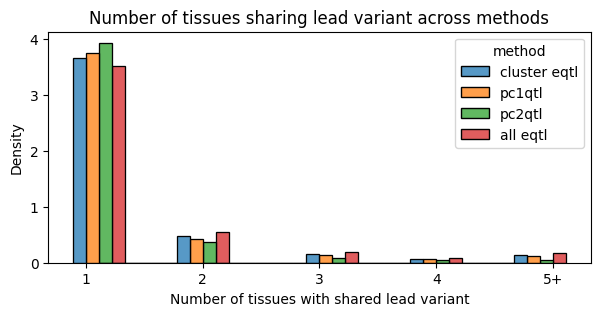

In [ ]:
fig, ax = plt.subplots(figsize=(7,3))

num_tissues_df['num_tissues_clip'] = num_tissues_df['num_tissues'].clip(0,5)
sns.histplot(num_tissues_df, hue='method', x='num_tissues_clip', stat='density', common_norm=False, ax=ax, multiple='dodge', shrink=2)
plt.title('Number of tissues sharing lead variant across methods')
plt.xlabel('Number of tissues with shared lead variant')

ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(['1', '2', '3', '4', '5+'])
plt.show()

#### Overlapping credible sets

In [ ]:
def get_overlap_upset(overlap_df, num_pcs = 2):
    overlap_df['e_overlap'] = overlap_df['num_e_overlap'] > 0

    # make indicator columns
    for i in range(num_pcs):
        overlap_df[f'pc{i+1}_overlap'] = overlap_df[f'num_pc{i+1}_overlap'] > 0
    
    # make upset_plot object
    upset_to_plot = overlap_df.set_index('e_overlap')
    for i in range(num_pcs):
        upset_to_plot = upset_to_plot.set_index(f'pc{i+1}_overlap', append=True)
    return upset_to_plot


In [ ]:
# all tissues, but must overlap in same tissue
# stacked bar to show if multiple egenes overlap or not
upset_dfs=[]
num_pcs = 10

for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')
    for i in range(num_pcs):
        overlap_df[f'num_pc{i+1}_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=i+1)
    upset_dfs.append(get_overlap_upset(overlap_df, num_pcs=num_pcs))
full_upset_df = pd.concat([df.assign(tissue_id=n) for df, n in zip(upset_dfs, tissue_ids)])

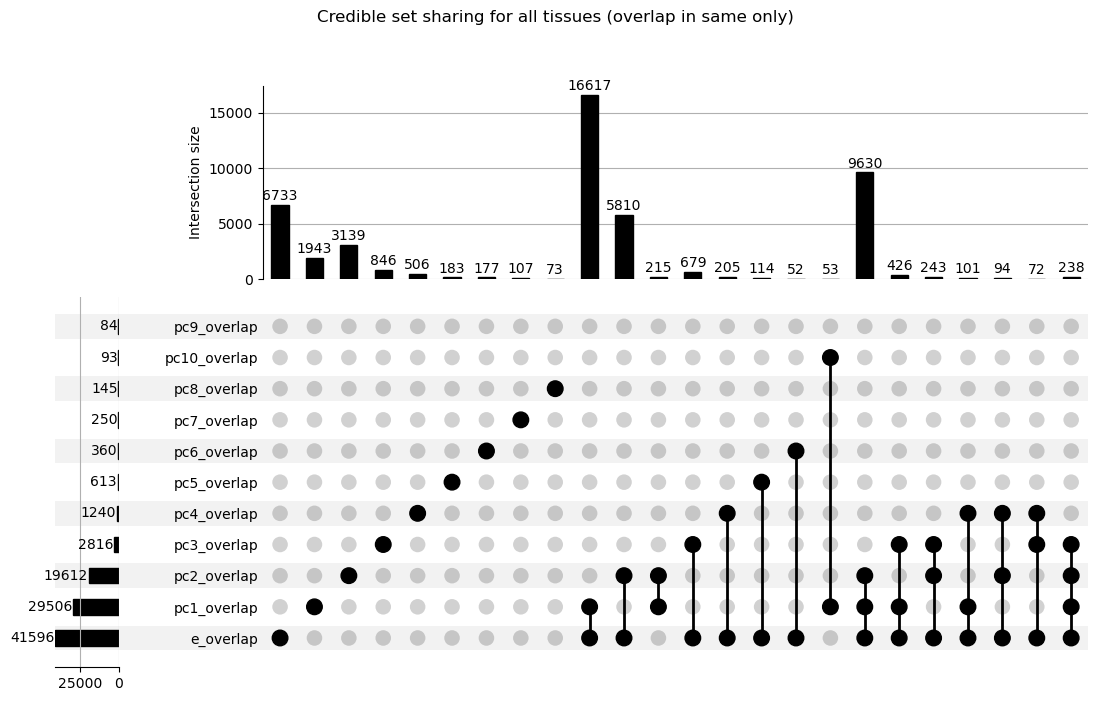

In [ ]:
upset = up.UpSet(full_upset_df,show_counts=True, min_subset_size=50)
upset.plot()
plt.suptitle('Credible set sharing for all tissues (overlap in same only)')
plt.show()

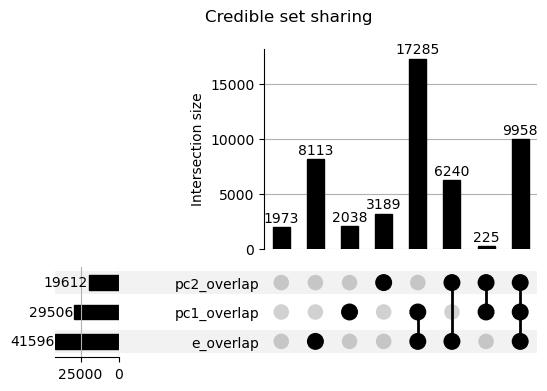

In [ ]:
upset_dfs=[]
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')
    overlap_df['num_pc1_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
    overlap_df['num_pc2_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=2)
    overlap_df['num_pc1_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
    overlap_df['num_pc2_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=2)
    upset_dfs.append(get_overlap_upset(overlap_df))
full_upset_df = pd.concat([df.assign(tissue_id=n) for df, n in zip(upset_dfs, tissue_ids)])

upset = up.UpSet(full_upset_df,show_counts=True)  # disable the default bar chart
upset.plot()
plt.suptitle('Credible set sharing')
plt.show()

In [ ]:
# upset for each tissue individually
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')
    overlap_df['num_pc1_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
    overlap_df['num_pc2_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=2)
    overlap_df['num_pc1_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
    overlap_df['num_pc2_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=2)
    
    upset = up.UpSet(get_overlap_upset(overlap_df), intersection_plot_elements=0,show_counts=True)  # disable the default bar chart
    upset.add_stacked_bars(by="multiple_e_shared", title="Shared by multiple egenes", elements=8)
    upset.plot()
    plt.suptitle(f'Credible set sharing for {tissue_id}')
    plt.show()

## poster

In [5]:
upset_dfs=[]
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')
    # pc overlaps
    overlap_df['num_pc1_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
    overlap_df['num_pc_overlap'] = overlap_df['pc_overlap'].str.count('pc')
    overlap_df['num_pchigher_overlap'] = overlap_df['num_pc_overlap'] - overlap_df['num_pc1_overlap']

    # make indicator columns 
    overlap_df['first pcQTL'] = overlap_df['num_pc1_overlap'] > 0
    overlap_df['other pcQTL'] = overlap_df['num_pchigher_overlap'] > 0
    overlap_df['eQTL'] = overlap_df['num_e_overlap'] > 0

    # multiple egenes
    overlap_df['multiple_e_shared'] = overlap_df['num_e_overlap']>1  

    upset_to_plot = overlap_df.set_index('eQTL').set_index('first pcQTL', append=True).set_index('other pcQTL', append=True)
    upset_dfs.append(upset_to_plot)
full_upset_df = pd.concat([df.assign(tissue_id=n) for df, n in zip(upset_dfs, tissue_ids)])

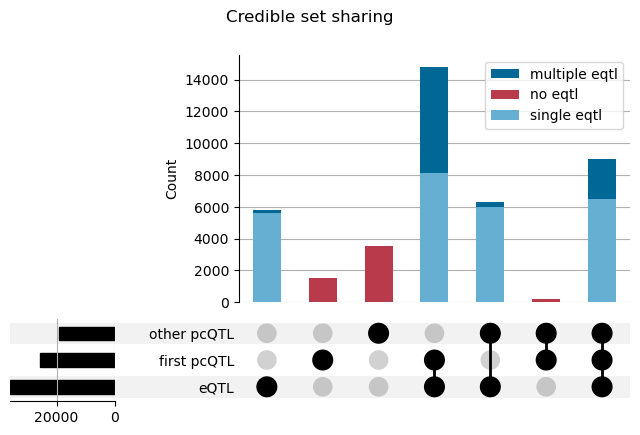

In [6]:
full_upset_df['multiple_e_shared_label'] = np.where(full_upset_df['multiple_e_shared'], 'multiple eqtl', 'single eqtl')
full_upset_df['multiple_e_shared_label'] = np.where(full_upset_df['num_e_overlap'] > 0, full_upset_df['multiple_e_shared_label'], 'no eqtl')

fig = plt.figure(figsize=(8, 4.5))
upset = up.UpSet(full_upset_df, intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_shared_label", title="Count", elements=8, colors=('#016895', '#B83A4B', '#67AFD2'))
upset.plot(fig=fig)


plt.suptitle('Credible set sharing')
plt.show()

In [8]:
upset_dfs=[]
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')
    # pc overlaps
    overlap_df['num_pc_overlap'] = overlap_df['pc_overlap'].str.count('pc')

    # make indicator columns 
    overlap_df['pcQTL'] = overlap_df['num_pc_overlap'] > 0
    overlap_df['eQTL'] = overlap_df['num_e_overlap'] > 0

    # multiple egenes
    overlap_df['multiple_e_shared'] = overlap_df['num_e_overlap']>1  

    upset_to_plot = overlap_df.set_index('eQTL').set_index('pcQTL', append=True)
    upset_dfs.append(upset_to_plot)
full_upset_df = pd.concat([df.assign(tissue_id=n) for df, n in zip(upset_dfs, tissue_ids)])

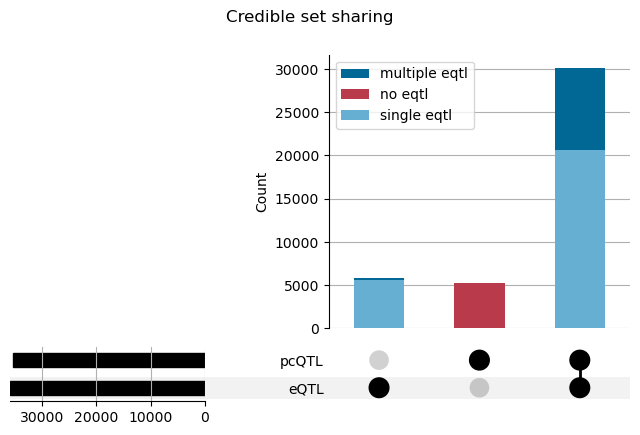

In [9]:
full_upset_df['multiple_e_shared_label'] = np.where(full_upset_df['multiple_e_shared'], 'multiple eqtl', 'single eqtl')
full_upset_df['multiple_e_shared_label'] = np.where(full_upset_df['num_e_overlap'] > 0, full_upset_df['multiple_e_shared_label'], 'no eqtl')

fig = plt.figure(figsize=(8, 4.5))
upset = up.UpSet(full_upset_df, intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_shared_label", title="Count", elements=8, colors=('#016895', '#B83A4B', '#67AFD2'))
upset.plot(fig=fig)


plt.suptitle('Credible set sharing')
plt.show()